In [1]:
import pygame
import os
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt
from matplotlib import animation
from collections import deque

pygame 2.6.1 (SDL 2.28.4, Python 3.9.21)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
print(torch.cuda.is_available())  # 應該為 True
print(torch.version.cuda)         # 應該列出 CUDA 版本
print(torch.backends.cudnn.version())  # cuDNN 版本


True
12.6
90701


In [3]:
script_dir = os.path.join(os.getcwd(), 'space_ship_game_RL')
if script_dir not in sys.path:
    sys.path.append(script_dir)

from setting import *
from game import Game


In [4]:
class SpaceShipEnv():
    def __init__(self):
        pygame.init()
        pygame.font.init()

        # 延後畫面初始化，等 render() 時才設置
        self.screen = None
        self.clock = pygame.time.Clock()
        self.fps = FPS

        self.game = Game()

        self.action_space = [0, 1, 2, 3]
        self.observation = self.game.state
        
        # 獎勵機制變數
        self.last_score = 0
        self.last_health = 100
        self.score_milestones = set()
        
        # 射擊相關追蹤變數
        self.last_bullet_count = 0
        self.last_enemy_count = 0
        self.consecutive_no_shoot = 0
        
        # 新增步數和效率追蹤
        self.step_count = 0
        self.max_steps = 15000  # 增加最大步數限制

    def step(self, action):
        self.step_count += 1
        # 記錄動作前的狀態
        prev_enemy_count = len(self.game.enemies) if hasattr(self.game, 'enemies') else 0

        self.game.update(action)

        if self.screen is None:
            self.game.draw()
        else:
            self.game.draw(self.screen)
            self.clock.tick(self.fps)

        # define the state by your game logic
        state = self.game.state

        # 使用 train02.ipynb 的獎勵算法
        reward = 0
        
        # 1. 基礎分數獎勵（主要獎勵來源）
        score_gain = self.game.score - self.last_score
        reward += score_gain * 2.0  # 降低分數獎勵權重
        self.last_score = self.game.score
        
        # 2. 血量變化懲罰
        current_health = self.game.player.sprite.health
        health_change = current_health - self.last_health
        if health_change < 0:
            health_ratio = current_health / 100.0
            base_penalty = abs(health_change) * 10.0
            # 血量越低懲罰越重（非線性增長)
            if health_ratio < 0.5:  # 血量低於50%時額外懲罰
                multiplier = 2.0 - health_ratio  # 0.5血量時multiplier=1.5, 0.1血量時=1.9
                reward -= base_penalty * multiplier
            else:
                reward -= base_penalty
                
        self.last_health = current_health
        
        # 3. 死亡懲罰
        if current_health <= 0:
            reward -= 200  # 提高死亡懲罰
            
        # 4. 簡化里程碑獎勵
        milestones = [100, 500, 1000, 2000, 5000, 10000]  # 大幅減少里程碑
        for milestone in milestones:
            if (self.game.score >= milestone and 
                milestone not in self.score_milestones):
                reward += 20  # 固定里程碑獎勵
                self.score_milestones.add(milestone)
                
        # 5. 射擊獎勵機制（簡化）
        current_bullet_count = len(self.game.player.sprite.bullets) if hasattr(self.game.player.sprite, 'bullets') else 0
        current_enemy_count = len(self.game.enemies) if hasattr(self.game, 'enemies') else 0

        # 檢測擊中敵人（主要射擊獎勵）
        if current_enemy_count < prev_enemy_count and score_gain > 0:
            enemy_killed = prev_enemy_count - current_enemy_count
            reward += enemy_killed * 20.0  # 提高擊殺獎勵
            
        # 6. 提高存活獎勵，並根據血量調整
        if current_health > 0:
            # 基礎存活獎勵
            base_survival_reward = 0.5  # 從 0.1 提高到 0.5
            # 血量越高，存活獎勵越高（鼓勵保持健康）
            health_bonus = (current_health / 100.0) * 0.3
            reward += base_survival_reward + health_bonus
            # 高分時的額外存活獎勵（鼓勵長期存活）
            if self.game.score > 1000:
                reward += 0.2 * (self.game.score / 1000.0)
            
        # 7. 勝利大獎
        if self.game.score >= 10000:
            reward += 1000  # 降低勝利獎勵
         
        done = not self.game.running or self.game.score >= 10000 or self.step_count >= self.max_steps
        info = self.game.score

        return state, reward, done, info

    def reset(self):
        self.game = Game()
        # ✅ 完整重置所有變數
        self.last_score = 0
        self.last_health = 100
        self.score_milestones.clear()
        self.last_bullet_count = 0
        self.last_enemy_count = 0
        self.consecutive_no_shoot = 0
        self.step_count = 0

        return self.game.state

    def render(self):
        if self.screen is None:
            self.screen = pygame.display.set_mode((WIDTH, HEIGHT))
            pygame.display.set_caption("SpaceShip RL Environment")

    def close(self):
        pygame.quit()

In [5]:
# Hyperparameters
num_episodes = 4000
batch_size = 64
gamma = 0.99
lr = 1e-4
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.999
memory_capacity = 80000  # 100000
target_update_freq = 1500   # 1000

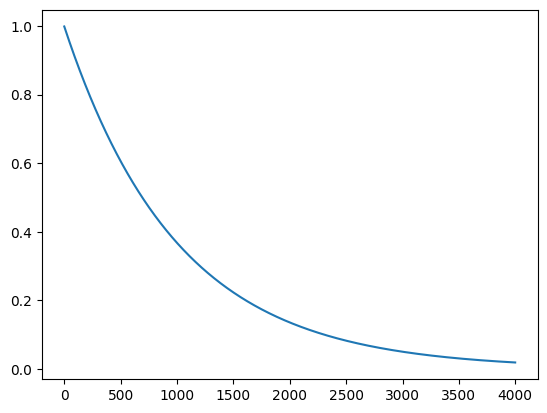

In [6]:
epsilon_list=[]
epsilon=epsilon_start
for i in range(num_episodes):
    epsilon = max(epsilon_end, epsilon * epsilon_decay)
    epsilon_list.append(epsilon)
plt.plot(epsilon_list)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# Hybrid DQN Model
class DQN(nn.Module):
    def __init__(self, numerical_dim, num_actions):
        super(DQN, self).__init__()
        
        # 視覺分支（CNN）
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        # 計算卷積輸出大小
        self.conv_output_size = 64 * 7 * 7
        
        # 數值分支（MLP）
        self.numerical_fc1 = nn.Linear(numerical_dim * 4, 128)  # *4因為堆疊了4幀
        self.numerical_fc2 = nn.Linear(128, 64)
        
        # 融合層
        self.fusion_fc1 = nn.Linear(self.conv_output_size + 64, 512)
        self.fusion_fc2 = nn.Linear(512, 256)
        self.output_fc = nn.Linear(256, num_actions)
        
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, visual_input, numerical_input):
        # 視覺特徵提取
        x = F.relu(self.conv1(visual_input))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        visual_features = x.view(x.size(0), -1)
        
        # 數值特徵提取
        # numerical_input shape: (batch_size, 4, feature_dim)
        numerical_flat = numerical_input.view(numerical_input.size(0), -1)  # 展平時間維度
        num_features = F.relu(self.numerical_fc1(numerical_flat))
        num_features = F.relu(self.numerical_fc2(num_features))
        
        # 特徵融合
        combined = torch.cat([visual_features, num_features], dim=1)
        x = F.relu(self.fusion_fc1(combined))
        x = self.dropout(x)
        x = F.relu(self.fusion_fc2(x))
        
        return self.output_fc(x)

In [ ]:
# 修改ReplayMemory以支持混合狀態
class ReplayMemory:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, visual_state, numerical_state, action, reward, next_visual_state, next_numerical_state, done):
        self.buffer.append((visual_state, numerical_state, action, reward, 
                           next_visual_state, next_numerical_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        
        visual_states, numerical_states, actions, rewards, next_visual_states, next_numerical_states, dones = zip(*batch)
        
        visual_states = torch.tensor(np.stack(visual_states), dtype=torch.float32, device=device)
        numerical_states = torch.tensor(np.stack(numerical_states), dtype=torch.float32, device=device)
        actions = torch.tensor(actions, dtype=torch.int64, device=device)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
        next_visual_states = torch.tensor(np.stack(next_visual_states), dtype=torch.float32, device=device)
        next_numerical_states = torch.tensor(np.stack(next_numerical_states), dtype=torch.float32, device=device)
        dones = torch.tensor(dones, dtype=torch.float32, device=device)
        
        return visual_states, numerical_states, actions, rewards, next_visual_states, next_numerical_states, dones

    def __len__(self):
        return len(self.buffer)

In [ ]:
# Preprocess frames (grayscale and resize to 84x84)
# 預處理影格：轉為灰階並縮放為 84x84

def preprocess_frame(frame):
    # frame 是 numpy array (H, W, 3)，先轉為 PIL Image
    # Input is a color image (RGB), convert to PIL format for easier processing.
    # 輸入是彩色圖像（RGB），轉成 PIL Image 以方便處理。
    image = Image.fromarray(frame)

    # 轉灰階
    # Convert the image to grayscale to reduce input complexity.
    # 將影像轉為灰階，降低輸入維度與計算量。
    image = image.convert('L')

    # resize 成 84x84
    # Resize the image to a standard 84x84 shape, as per DQN convention.
    # 依照 DQN 的慣例將影像統一縮放至 84x84。
    image = image.resize((84, 84), Image.Resampling.BILINEAR)  # or NEAREST, or LANCZOS

    # 轉回 numpy 並正規化
    # Convert back to NumPy and normalize pixel values to [0, 1].
    # 轉回 NumPy 格式並將像素值標準化到 [0, 1]。
    frame = np.asarray(image, dtype=np.float32) / 255.0

    return frame


def stack_frames(stacked_frames, state, is_new_episode):
    # 預處理目前影格
    frame = preprocess_frame(state)

    if is_new_episode or stacked_frames is None:
        # If it's a new episode or no previous frames, initialize with 4 identical frames
        # 若是新的一集或是尚未初始化，則用目前影格複製 4 次形成初始堆疊
        stacked_frames = deque([frame]*4, maxlen=4)
    else:
        # 否則把新影格加入到堆疊中，自動捨棄最舊的
        stacked_frames.append(frame)

    # Stack the 4 frames along the first dimension: shape becomes (4, 84, 84)
    # 沿著第一維（channel）堆疊成 4 通道輸入：形狀變成 (4, 84, 84)
    stacked_state = np.stack(stacked_frames, axis=0)

    return stacked_state, stacked_frames

def extract_game_features(game):
    """提取遊戲的數值特徵"""
    features = []
    
    # 玩家信息
    player_x = game.player.sprite.rect.centerx / WIDTH  # 標準化位置
    player_y = game.player.sprite.rect.centery / HEIGHT
    player_health = game.player.sprite.health / 100.0
    features.extend([player_x, player_y, player_health])
    
    # 敵人信息 (取最近的5個敵人)
    enemies = list(game.enemies)
    # 按距離排序，取最近的5個
    if enemies:
        player_pos = (game.player.sprite.rect.centerx, game.player.sprite.rect.centery)
        enemies = sorted(enemies, 
                        key=lambda e: ((e.rect.centerx - player_pos[0])**2 + 
                                     (e.rect.centery - player_pos[1])**2)**0.5)[:5]
    
    for i in range(5):
        if i < len(enemies):
            enemy = enemies[i]
            enemy_x = enemy.rect.centerx / WIDTH
            enemy_y = enemy.rect.centery / HEIGHT
            # 計算與玩家的相對距離
            distance = ((enemy.rect.centerx - game.player.sprite.rect.centerx)**2 + 
                       (enemy.rect.centery - game.player.sprite.rect.centery)**2)**0.5 / 800
            features.extend([enemy_x, enemy_y, distance])
        else:
            features.extend([0, 0, 1])  # 無敵人時的默認值
    
    # 子彈信息
    bullet_count = len(game.player.sprite.bullets) / 10.0  # 標準化
    features.append(bullet_count)
    
    # 遊戲狀態
    score_normalized = min(game.score / 10000.0, 1.0)  # 標準化分數
    features.append(score_normalized)
    
    return np.array(features, dtype=np.float32)

def create_hybrid_state(game):
    """創建混合狀態：影像 + 數值特徵"""
    # 影像特徵
    visual_frame = preprocess_frame(game.state)
    
    # 數值特徵
    numerical_features = extract_game_features(game)
    
    return visual_frame, numerical_features

def stack_hybrid_frames(stacked_visual_frames, stacked_numerical_frames, game, is_new_episode):
    """堆疊混合狀態"""
    visual_frame, numerical_features = create_hybrid_state(game)
    
    if is_new_episode or stacked_visual_frames is None:
        # 初始化時複製4次
        stacked_visual_frames = deque([visual_frame]*4, maxlen=4)
        stacked_numerical_frames = deque([numerical_features]*4, maxlen=4)
    else:
        # 添加新的幀
        stacked_visual_frames.append(visual_frame)
        stacked_numerical_frames.append(numerical_features)
    
    # 堆疊
    stacked_visual = np.stack(stacked_visual_frames, axis=0)  # (4, 84, 84)
    stacked_numerical = np.stack(stacked_numerical_frames, axis=0)  # (4, feature_dim)
    
    return stacked_visual, stacked_numerical, stacked_visual_frames, stacked_numerical_frames

In [ ]:
# 初始化環境和模型
env = SpaceShipEnv()
num_actions = len(env.action_space)

# 計算數值特徵維度
sample_features = extract_game_features(env.game)
numerical_dim = len(sample_features)
print(f"Numerical feature dimension: {numerical_dim}")

# 建立混合DQN模型
policy_net = DQN(numerical_dim, num_actions).to(device)
target_net = DQN(numerical_dim, num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=lr)
memory = ReplayMemory(memory_capacity)

# 載入模型邏輯保持不變，但需要確保模型架構匹配
if os.path.exists('checkpoint.pth'):
    checkpoint = torch.load('checkpoint.pth', map_location=device)
    policy_net.load_state_dict(checkpoint['policy_net'])
    target_net.load_state_dict(checkpoint['target_net'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_episode = checkpoint['episode'] + 1
    total_steps = checkpoint['total_steps']
    best_score = checkpoint['best_score']
    epsilon = checkpoint['epsilon']
    reward_history = checkpoint['reward_history']
    score_history = checkpoint['score_history']
    print(f"Loaded checkpoint from episode {start_episode}, best score: {best_score:.2f}, epsilon={epsilon:.3f}")
else:
    start_episode = 0
    total_steps = 0
    best_score = float('-inf')
    epsilon = epsilon_start
    reward_history = []
    score_history = []
    
# 訓練迴圈
for episode in range(start_episode, 4000):
    state = env.reset()
    visual_state, numerical_state, stacked_visual_frames, stacked_numerical_frames = stack_hybrid_frames(
        None, None, env.game, True)
    total_reward, done = 0, False

    while not done:
        # ε-greedy 策略
        if random.random() < epsilon:
            action = random.choice(env.action_space)
        else:
            with torch.no_grad():
                visual_tensor = torch.tensor(visual_state, dtype=torch.float32, device=device).unsqueeze(0)
                numerical_tensor = torch.tensor(numerical_state, dtype=torch.float32, device=device).unsqueeze(0)
                action = policy_net(visual_tensor, numerical_tensor).argmax(dim=1).item()

        # 執行動作
        next_state, reward, done_, score = env.step(action)
        done = done_
        total_reward += reward

        # 獲取下一個狀態
        next_visual_state, next_numerical_state, stacked_visual_frames, stacked_numerical_frames = stack_hybrid_frames(
            stacked_visual_frames, stacked_numerical_frames, env.game, False)
        
        # 存儲經驗
        memory.push(visual_state, numerical_state, action, reward, 
                   next_visual_state, next_numerical_state, done)
        
        visual_state, numerical_state = next_visual_state, next_numerical_state

        # 訓練模型
        if len(memory) >= batch_size:
            visual_states, numerical_states, actions, rewards, next_visual_states, next_numerical_states, dones = memory.sample(batch_size)

            with torch.no_grad():
                next_q_values = target_net(next_visual_states, next_numerical_states).max(1)[0]
                target_q = rewards + gamma * next_q_values * (1 - dones)

            current_q = policy_net(visual_states, numerical_states).gather(1, actions.unsqueeze(1)).squeeze(1)
            loss = F.mse_loss(current_q, target_q)

            optimizer.zero_grad()
            loss.backward()
            # 添加梯度裁剪
            torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
            optimizer.step()

        # 更新 target 網路
        total_steps += 1
        if total_steps % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

    # 其餘訓練邏輯保持不變
    epsilon = max(epsilon_end, epsilon * epsilon_decay)
    reward_history.append(total_reward)
    score_history.append(score)

    print(f"Episode {episode + 1:3d}, Reward: {total_reward:7.2f}, Score: {score:4d}, Epsilon: {epsilon:5.3f}")

    # 儲存模型邏輯保持不變
    if (episode + 1) % 50 == 0 or score > best_score:
        best_score = max(best_score, score)
        torch.save({
            'policy_net': policy_net.state_dict(),
            'target_net': target_net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epsilon': epsilon,
            'episode': episode,
            'total_steps': total_steps,
            'best_score': best_score,
            'reward_history': reward_history,
            'score_history': score_history,
        }, 'checkpoint.pth')
        print(f"Checkpoint saved at episode {episode + 1}, best score: {best_score:.2f}")

env.close()

C:\Users\nclabb\AppData\Local\Temp\ipykernel_7236\781225401.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoint.pth', map_location=devic

Loaded checkpoint from episode 3465, best score: 6810.00, epsilon=0.031


KeyboardInterrupt: 

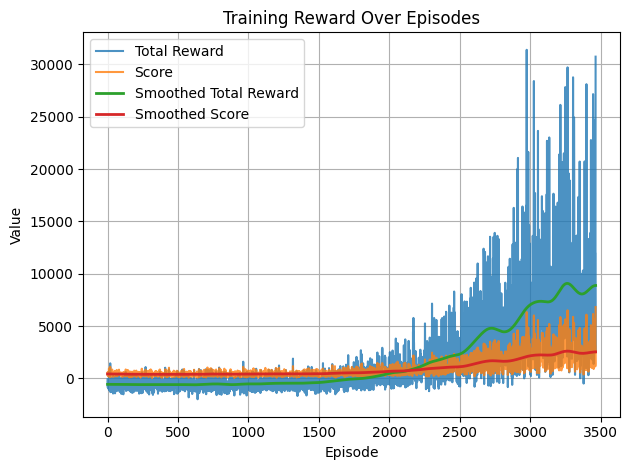

In [12]:
from scipy.ndimage import gaussian_filter1d

reward_smooth = gaussian_filter1d(reward_history, sigma=50)
score_smooth = gaussian_filter1d(score_history, sigma=50)

# 畫圖
# plt.figure(figsize=(10, 5))
plt.plot(reward_history, label='Total Reward', alpha=0.8)
plt.plot(score_history, label='Score', alpha=0.8)
plt.plot(reward_smooth, label='Smoothed Total Reward', linewidth=2)
plt.plot(score_smooth, label='Smoothed Score', linewidth=2)

plt.legend(loc='upper left')
plt.xlabel("Episode")
plt.ylabel("Value")
plt.title("Training Reward Over Episodes")
plt.grid(True)
plt.tight_layout()
# plt.savefig("dqn_training_curve.png")

